In [16]:
import torch
import os
import numpy as np
import torch.nn as nn
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid
from torch.optim import Adam

In [17]:
import requests
url = 'https://filesender.aarnet.edu.au/download.php??token=f7f699a7-5e9c-4723-a6ae-48b54375501a&files_ids=26088805'
response = requests.get(url)

if response.status_code == 200:
    with open('keras_png_slices_data.zip', 'wb') as file:
        file.write(response.content)

In [7]:
from zipfile import ZipFile
with ZipFile('keras_png_slices_data.zip', 'r') as zip_file:
    zip_file.extractall('.')

In [26]:
class UnlabeledImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir) if img.endswith(('.png', '.jpg', '.jpeg'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

# create a transofrm to apply to each datapoint
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    torchvision.transforms.Resize((64,64),
                                  interpolation = transforms.InterpolationMode.NEAREST_EXACT),
    transforms.ToTensor()])

# download the MNIST datasets
dataset = ImageFolder('./keras_png_slices_data', transform=transform)

# create train and test dataloaders
batch_size = 1
train_loader = DataLoader(dataset=UnlabeledImageDataset('./keras_png_slices_data/keras_png_slices_seg_test',
                                                        transform=transform),
                          batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=UnlabeledImageDataset('./keras_png_slices_data/keras_png_slices_seg_train',
                                                        transform=transform),
                         batch_size=batch_size, shuffle=False)

d = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
class Encoder(nn.Module):

    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

        self.training = True

    def forward(self, x):
        h_       = self.LeakyReLU(self.FC_input(x))
        h_       = self.LeakyReLU(self.FC_input2(h_))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                     # encoder produces mean and log of variance
                                                       #             (i.e., parateters of simple tractable normal distribution "q"

        return mean, log_var

In [20]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        h     = self.LeakyReLU(self.FC_hidden(x))
        h     = self.LeakyReLU(self.FC_hidden2(h))

        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat

In [21]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(d)        # sampling epsilon
        z = mean + var*epsilon                          # reparameterization trick
        return z


    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat            = self.Decoder(z)

        return x_hat, mean, log_var

In [22]:
x_dim = 64*64
hidden_dim = int((64*64)/2)
latent_dim = 2

encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(d)

In [23]:
BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD


optimizer = Adam(model.parameters(), lr=0.0001)

In [27]:
print("Start training VAE...")
model.train()

for epoch in range(30):
    overall_loss = 0
    for batch_idx, x in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(d)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)

        overall_loss += loss.item()

        loss.backward()
        optimizer.step()

    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))

print("Finish!!")

Start training VAE...
	Epoch 1 complete! 	Average Loss:  697.8164459284717
	Epoch 2 complete! 	Average Loss:  620.5233160479073
	Epoch 3 complete! 	Average Loss:  593.7069684163861
	Epoch 4 complete! 	Average Loss:  585.3221896401645
	Epoch 5 complete! 	Average Loss:  581.070144175605
	Epoch 6 complete! 	Average Loss:  578.8050356701593
	Epoch 7 complete! 	Average Loss:  575.2263593304882
	Epoch 8 complete! 	Average Loss:  572.8237893682378
	Epoch 9 complete! 	Average Loss:  570.0392451558544
	Epoch 10 complete! 	Average Loss:  568.8685772019417
	Epoch 11 complete! 	Average Loss:  567.7995810043307
	Epoch 12 complete! 	Average Loss:  566.1257801934062
	Epoch 13 complete! 	Average Loss:  565.2651743739569
	Epoch 14 complete! 	Average Loss:  564.5634209789184
	Epoch 15 complete! 	Average Loss:  562.8060564634769
	Epoch 16 complete! 	Average Loss:  562.7350794895798
	Epoch 17 complete! 	Average Loss:  561.8851287448384
	Epoch 18 complete! 	Average Loss:  561.4433888247439
	Epoch 19 comple

/tmp/ipython-input-3847547530.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit


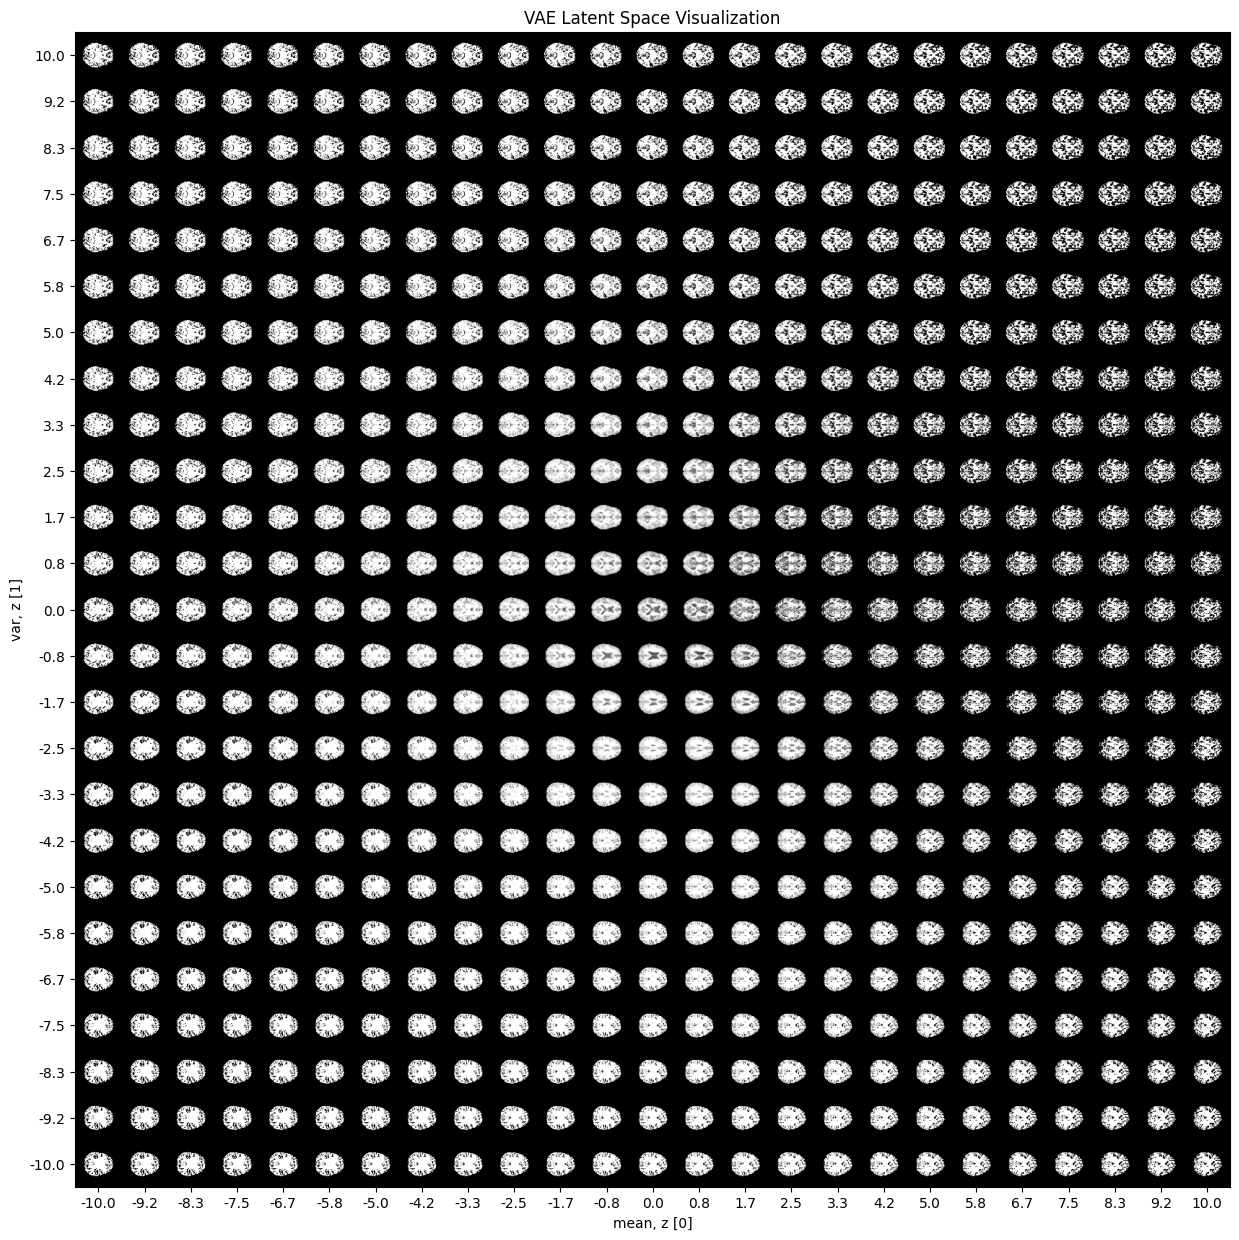

In [35]:
def plot_latent_space(model, scale=1.0, n=25, digit_size=64, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(d)
            x_decoded = model.Decoder(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z [0]")
    plt.ylabel("var, z [1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(model, scale = 10)